## Importing the required libiraries

In [77]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

## Importing the dataset

In [30]:
df = pd.read_csv(
    "SMSSpamCollection.csv",
    sep="\t",
    header=None,
    names=["label", "message"],
    encoding="utf-8"
)

In [31]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Data Exploration

#### Class Distribution

In [39]:
df['label'].value_counts().unique()

array([4825,  747])

In [32]:
df['label'].value_counts(normalize=True) * 100

label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

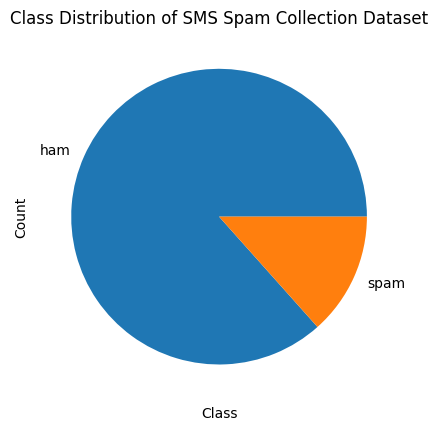

In [41]:
df['label'].value_counts().plot(kind='pie')
plt.title("Class Distribution of SMS Spam Collection Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Message length based on Labels

In [58]:
df['message_length'] = df['message'].apply(len)

df.groupby('label')['message_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


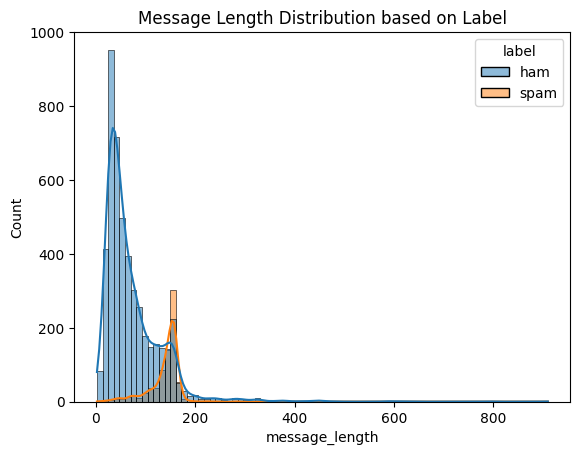

In [60]:
sns.histplot(data=df, x='message_length', hue='label', bins=80, kde=True)
plt.title("Message Length Distribution based on Label")
plt.show()

#### Word Counts Based on Labels

In [61]:
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

df.groupby('label')['word_count'].mean()

label
ham     14.310259
spam    23.911647
Name: word_count, dtype: float64

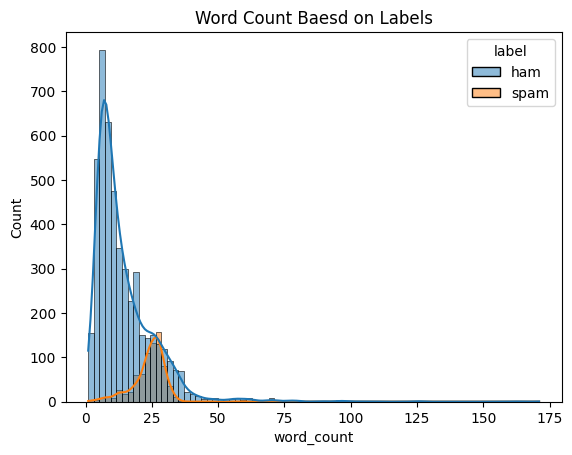

In [67]:
sns.histplot(data=df, x='word_count', hue='label', bins=80, kde=True)

plt.title("Word Count Baesd on Labels")
plt.show()

In [79]:
from collections import Counter
spam_words = Counter(" ".join(df[df['label']=='spam']['message']).split()).most_common(10)
ham_words = Counter(" ".join(df[df['label']=='ham']['message']).split()).most_common(10)

print("most common words in spam messages: ", spam_words)
print ("most common words in ham messages: ", ham_words)

most common words in spam messages:  [('to', 607), ('a', 360), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143)]
most common words in ham messages:  [('to', 1538), ('you', 1462), ('I', 1439), ('the', 1029), ('a', 977), ('i', 742), ('and', 739), ('in', 736), ('u', 651), ('is', 645)]


### Word Cloud

In [81]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_message'] = df['message'].apply(clean_text)

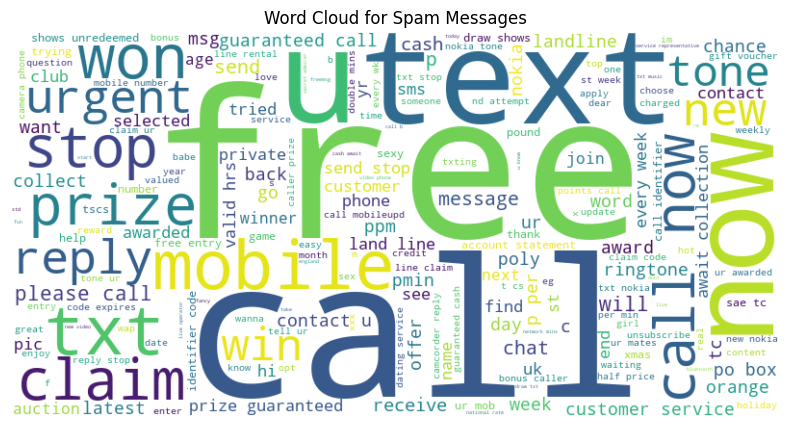

In [92]:
ham_text = " ".join(df[df['label'] == 'spam']['clean_message'])

ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Spam Messages")
plt.show()

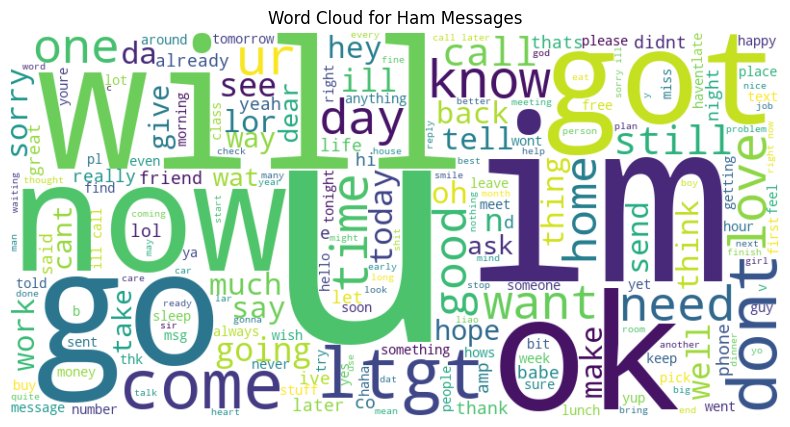

In [93]:
ham_text = " ".join(df[df['label'] == 'ham']['clean_message'])

ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Ham Messages")
plt.show()

#### Encoding Lables

In [94]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

df['label']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

### Text Preprocessing

#### Downloading requied nltk 

In [97]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [96]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['message'].apply(preprocess_text)

### Feature Extraction

In [100]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=5000,
    min_df=2
)

X = tfidf.fit_transform(df['clean_text'])
y = df['label']

In [104]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50035 stored elements and shape (5572, 5000)>

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Model Training

In [109]:
class LinearSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - y[idx] * x_i)
                    self.b -= self.lr * y[idx]

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        return np.sign(linear_output)

In [110]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()